# Challenge: Predicting sex from EEG data
The idea is to reproduce the results on the [Nature publication](https://www.nature.com/articles/s41598-018-21495-7.pdf.)
Abstract: " We have excellent skills to extract sex from visual assessment of human faces but assessing sex from human brain rhythms seems impossible. Using deep convolutional neural networks, with unique potential to find subtle differences in apparent similar patterns, we explore if brain brain rhythms from either sex contain sex specific information. Here we show, in a ground truth scenario, that a deep neural net can predict se from sclp electroencephalograms with an accuracy of > 80% (p < 10-5), revealing that brain rhythms are sex specific".

## Challenge goals
In the dataset, the objective is to predict the gender from someone based on 40 windows of 2 seconds taken during sleep.
## Dataset
Each sample represent 40 independent segments of 2 seconds of 7 EEG channel samples at 250 Hz. 
The training matrix has shape: N_train x 40 x 7 x 500. The testing matrix has shape: N_test x 40 x 7 x 500.

**Labels**: The prediction is a label in {1, 2} where 1 stands for male and 2 for female.

**Benchmark**: Random forest on dummy features (min, max, mean, abs mean value) of EEG signals.

**Public Metric**: *accuracy_score* from *scikit-learn*

## Approach: Usage of  2DCNN to extract the hidden features (Using as analogy the image classification problem)

https://arxiv.org/pdf/1312.4400.pdf: Conventional convolutional neural networks perform convolution in the lower layers of the network. For classification, the feature maps of the last convolutional layer are vectorized and fed into fully connected layers followed by a softmax logistic regression layer. This structure bridges the convolutional structure with traditional neural network classifiers. It treats the convolutional layers as feature extractors, and the resulting feature is classified in a traditional way.

However, the fully connected layers are prone to overfitting, thus hampering the generalization ability of the overall network. Dropout is proposed by Hinton et al as a regularizer which randomly sets half of the activations to the fully connected layers to zero during training. It has improved the generalization ability and largely prevents overfitting.

In this paper, we propose another strategy called global average pooling to replace the traditional fully connected layers in CNN. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Futhermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input. We can see global average pooling as a structural regularizer that explicitly enforces feature maps to be confidence maps of concepts (categories). This is made possible by the mlpconv layers, as they makes better approximation to the confidence maps than GLMs.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
#import seaborn as sns; sns.set()

# N_train x 40 x 7 x 500
# 946 samples, 40 segments, 7 EEG channels, 250 Hz samples
fX_train = h5py.File('X_train_new.h5', 'r')#h5py.File('X_train_w0MYA72.h5', 'r')
fX_test = h5py.File('X_test_new.h5', 'r')#h5py.File('X_test_lNrTMS6.h5', 'r')
# column names --> [id, label]
fy_train = np.genfromtxt('y_train_AvCsavx.csv', delimiter=',', names=True)
#fy_test = np.genfromtxt('y_lol_kSI9ffn.csv', delimiter=',', names=True) 
# Transform into numpy arrays
iX_train = np.array(fX_train['features'])
iX_test = np.array(fX_test['features'])
iy_train = np.array(fy_train['label'])
#y_test = np.array(fy_test['label'])
print("""
Train       (X) dataset shape: {} --> Train (y) dataset shape: {}
Validation  (X) dataset shape: {}""".format(iX_train.shape, iy_train.shape, iX_test.shape))


Train       (X) dataset shape: (946, 40, 7, 500) --> Train (y) dataset shape: (946,)
Validation  (X) dataset shape: (946, 40, 7, 500)


In [2]:
def data_preprocessing(X_data, y_data, zero_bursts = True, rand_permutation = False):
    """Proprocess data by applying zero bursts and/or up sampling for imbalanced sets"""
    if zero_bursts == False and up_sampling == False: return X_data
    # Computes zero-burst for a for over each array dimension
    elif zero_bursts == True:
        print("Applying zero-burst on the dataset...\n")
        # Iterate over the number of samples
        for i in range(X_data.shape[0]):
            indices = np.random.choice(np.arange(X_data.shape[-1]), replace=False,
                                       size=int(X_data.shape[-1] * 0.3)) #0.4
            X_data[i, :][indices] = 0
            #  Create also random permutation to enable generalization of the cnn
            if rand_permutation == True:
                perm_idxs = np.random.choice(np.arange(X_data.shape[-1]), replace=False,
                                             size=int(X_data.shape[-1] * 0.3)) #0.5
                X_data[i, :][perm_idxs] = X_data[i, :][np.random.permutation(perm_idxs)]
        return X_data
    else: return X_data
    
def up_sampling(X_data, y_data, info=True):
    """Up-samples the imbalanced X_data using the minority labeled, it is assummed the X_data has been already flattened"""
    print("Up-sampling the minority class from y --> #(0 Labels) : {}, #(1 Labels) : {}\n""".format(sum(y_data == 0), sum(y_data == 1)))
    idx_0 = [i for i in range(len(y_data)) if y_data[i] == 0] # Label 0 is mayority
    idx_1 = [i for i in range(len(y_data)) if y_data[i] == 1] # Label 1 is minority
    X_data_1_upsampled = resample(X_data[idx_1], replace = True, n_samples = len(idx_0), random_state = 10)
    X_data_new = np.concatenate((X_data[idx_0], X_data_1_upsampled), axis=0)
    y_data_new = np.concatenate((y_data[idx_0], (1,)*X_data_1_upsampled.shape[0]), axis=0)
    if info == True:
        print("New Up-sampled X dataset shape: {}, y dataset shape: {}\n".format(X_data_new.shape, y_data_new.shape))
        print("""Up-sampled datasets y--> #(0 Labels) : {}, #(1 Labels) : {}\n""".format(sum(y_data_new == 0), sum(y_data_new == 1)))
    return X_data_new, y_data_new

def feature_normalize(dataset, info = False):
    """Returns the dataset normalized along the first axis (0), normalizing each feature of the array"""
    mean = np.mean(dataset, axis=0)
    var = np.std(dataset, axis=0)
    dataset_new = (dataset - mean)/var
    if info == True: 
        print("""Normalized dataset of shape {}
                 5 first means: {} 
                 5 first vars : {}\n""".format(dataset_new.shape, mean[1:5], var[1:5]))
    return dataset_new

def dataset_segmentation(X_data, y_data, N_SAMPLES, N_SEGMENTS, TIME_SAMPLES, N_CHANNELS, info = False, validation = False):
    """
    It returns the reshaped data set to feed into the CNN.
    The reshaped dataset is in the form: N_SAMPLES x TIME_SAMPLE x (N_SEGMENTS*N_CHANNELS)
    The quantity N_SAMPLES*N_SEGMENTS define the quantity of observations.
    Input dataset of size: N_train x 40 x 7 x 500
    --> 946 samples, 40 segments, 7 EEG channels, 250 Hz samples
    """
    X_data_new = np.zeros([N_SAMPLES*N_SEGMENTS, TIME_SAMPLES, N_CHANNELS], dtype=np.float32)
    y_data_new = np.empty([N_SAMPLES*N_SEGMENTS,], dtype=np.int)
    if validation == False:
        y_data_new = np.zeros([N_SAMPLES*N_SEGMENTS,])
        for i in range(N_SAMPLES):
            for j in range(N_SEGMENTS):
                for k in range(N_CHANNELS):
                    X_data_new[i+j, :, k] = X_data[i, j, k, :].T
                y_data_new[i+j] = y_data[i]
        if info == True:
            print("New segmented X dataset shape: {}, y dataset shape: {}\n".format(X_data_new.shape, y_data_new.shape))
            print("""Segmentation of y--> #(0 Labels) : {}, #(1 Labels) : {}\n""".format(sum(y_data_new == 0), sum(y_data_new == 1)))
        return X_data_new, y_data_new
    else:
        for i in range(N_SAMPLES):
            for j in range(N_SEGMENTS):
                X_data_new[i+j, :, :] = X_data[i, j, :, :].T
        if info == True:
            print("\nNew segmented X dataset shape: {}".format(X_data_new.shape))
        return X_data_new

def dataset_back_to_original(model_type, architecture, y_data, N_SAMPLES, N_SEGMENTS, export=True, use_average=False):
    """
    Returns the original shape of y_data by doing the backwards processing of dataset_segmentation.
    and outputs a csv file with predicted categories.
    """
    y_data_new = np.zeros([N_SAMPLES,], dtype=np.int)
    for i in range(N_SAMPLES):
        if use_average == False:
            y_data_new[i] = y_data[i*N_SEGMENTS+1]
        else:
            average = np.mean([y_data[i*N_SEGMENTS:(i+1)*N_SEGMENTS]])
            y_data_new[i] = round(average)
        
    if export == True:
        struc_array = np.array([(n, y_data_new[n]) for n in range(len(y_data_new))])
        y_test = np.savetxt('y_test_pred_model{}_arch{}.csv'.format(model_type, architecture), struc_array, fmt=["%d", "%d"], delimiter=',', header='id,label', comments='')
        
    return y_data_new

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

test_size = 0.3
# Split X_train_model, y_train_model in train and test dataset to the CNN
X_train, X_test, y_train, y_test = train_test_split(iX_train, iy_train, test_size=test_size, random_state=10)
print("""Spliting datasets into TRAIN/TEST at {}
         X_train shape: {} --> y_train shape: {}
         X_test  shape: {} --> y_test  shape: {}
         """.format(1-test_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("""Original y_train--> #(0 Labels) : {}, #(1 Labels) : {}\n""".format(sum(y_train == 0), sum(y_train == 1)))
# Default parameters
N_SAMPLES = X_train.shape[0] #946
TIME_SAMPLES = 500 # Its fixed, at 500!
N_SEGMENTS = 40 # Can be changed, 40 the max!, 20 work preventing overfitting!
N_CHANNELS = 7 # Its fixed, at 7!
N_OBS = N_SAMPLES*N_SEGMENTS

print("""Parameters used for TRAINING MODEL:
         N_SAMPLES     = {},
         TIME_SAMPLES  = {}, 
         N_SEGMENTS    = {}, 
         N_CHANNELS    = {},
         N_OBS         = {}\n""".format(N_SAMPLES, TIME_SAMPLES, N_SEGMENTS, N_CHANNELS, N_OBS))

# Define input data to feed into the CNN
X_train, y_train = dataset_segmentation(X_train, y_train, N_SAMPLES, N_SEGMENTS, TIME_SAMPLES, N_CHANNELS, info=True)
X_train = X_train.reshape((N_OBS, TIME_SAMPLES*N_CHANNELS))
print("Up-sampling to obtain a balanced set...\n")
X_train, y_train = up_sampling(X_train, y_train, info=True)
print("Using zero-burst on the training set to avoid overfitting...\n")
X_train = data_preprocessing(X_train, y_train, zero_bursts = False, rand_permutation=False)
print("Applying normalization on the data and reshaping the array...\n")
X_train = feature_normalize(X_train, info = True)
y_train = to_categorical(y_train)

Spliting datasets into TRAIN/TEST at 0.7
         X_train shape: (662, 40, 7, 500) --> y_train shape: (662,)
         X_test  shape: (284, 40, 7, 500) --> y_test  shape: (284,)
         
Original y_train--> #(0 Labels) : 515, #(1 Labels) : 147

Parameters used for TRAINING MODEL:
         N_SAMPLES     = 662,
         TIME_SAMPLES  = 500, 
         N_SEGMENTS    = 40, 
         N_CHANNELS    = 7,
         N_OBS         = 26480

New segmented X dataset shape: (26480, 500, 7), y dataset shape: (26480,)

Segmentation of y--> #(0 Labels) : 26333, #(1 Labels) : 147

Up-sampling to obtain a balanced set...

Up-sampling the minority class from y --> #(0 Labels) : 26333, #(1 Labels) : 147

New Up-sampled X dataset shape: (52666, 3500), y dataset shape: (52666,)

Up-sampled datasets y--> #(0 Labels) : 26333, #(1 Labels) : 26333

Using zero-burst on the training set to avoid overfitting...

Applying normalization on the data and reshaping the array...

Normalized dataset of shape (52666, 3500)
 

In [4]:
def build_model(model_type = '1DCNN', architecture = 'v1', show_summary = False):
    # Define the CNN neural net depending on the model
    print("Creating the sequencial neural net...")
    model = Sequential()
    if model_type == '1DCNN':
        if architecture == 'v1':
            # Predicting 72%, train with 20 or 40 segments 
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv1D(8, 3, activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.5))
            model.add(Conv1D(8, 2, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dropout(0.3))
            model.add(Dense(2, activation='softmax'))
        elif architecture == 'v2':
            # Predicting 72%, train with 20 or 40 segments
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv1D(8, 4, activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.5))
            model.add(Conv1D(8, 3, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dropout(0.5))
            model.add(Dense(2, activation='softmax'))
        elif architecture == 'v3':
            # Should predict 72% or more!
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv1D(8, 3, activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.5))
            model.add(Conv1D(4, 2, activation='relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.5))
            model.add(Conv1D(4, 2, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dropout(0.5))
            model.add(Dense(2, activation='softmax'))
        else:
            # Should predict 72% or more!
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv1D(8, 3, activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.5))
            model.add(Conv1D(8, 2, activation='relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.5))
            model.add(Conv1D(8, 2, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dropout(0.5))
            model.add(Dense(2, activation='softmax'))
            
            
    elif model_type == '2DCNN':
        if architecture == 'v1':
            # The input is reshaped to (TIME_SAMPLES, N_CHANNELS, 1)
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS, 1), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv2D(8, kernel_size=[3, 3], activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(MaxPooling2D(pool_size=[2, 2]))
            model.add(Dropout(0.3))
            model.add(Conv2D(8, kernel_size=[2, 2], activation='relu'))
            model.add(GlobalAveragePooling2D())
            model.add(Dropout(0.3))
            model.add(Dense(2, activation='softmax'))
        elif architecture == 'v2':
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS, 1), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(Conv2D(8, kernel_size=[3, 3], activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.3))
            model.add(Conv2D(8, kernel_size=[2, 2], activation='relu'))
            model.add(MaxPooling2D(pool_size=[2, 2]))
            model.add(Dropout(0.3))
            model.add(Conv2D(8, kernel_size=[2, 2], activation='relu'))
            model.add(GlobalAveragePooling2D())
            model.add(Dropout(0.3))
            model.add(Dense(2, activation='softmax'))
        else:
            print("Architecture not created!\n")
            
    elif model_type == 'LSTM': 
        # This model works poorly compared to the other ones...!
        if architecture == 'v1':
            # Experimental model
            model.add(Reshape((TIME_SAMPLES, N_CHANNELS), input_shape=(TIME_SAMPLES*N_CHANNELS,)))
            model.add(LSTM(16, activation='relu', input_shape=(TIME_SAMPLES, N_CHANNELS)))
            model.add(Dropout(0.3))
            model.add(Dense(2, activation='softmax'))
        else:
            print("Architecture not created!\n")
                      
    else: print("-----Model not recognized-----!!\n")
    if show_summary == True:
        print(model.summary())
    
    return model

# Choose model
#arch_type = 'v4' # 'v1', 'v2', 'v3'
#model_type = '1DCNN' # '1DCNN', '2DCNN', 'LSTM'
#model = build_model(model_type, architecture=arch_type, show_summary=True)
all_model_types = ['1DCNN', '2DCNN']
all_arch_types = {
    '1DCNN': ['v1', 'v2', 'v3', 'v4'],
    '2DCNN': ['v1', 'v2']
}
# Initialize dictorianary with all models
all_models = {
    '1DCNN': {
        'v1': None,
        'v2': None,
        'v3': None,
        'v4': None
    },
    '2DCNN': {
        'v1': None,
        'v2': None
    }
}
# Iterate over each architecture and model, using a single dictionary
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        print("Building model {} with architecture {}...".format(model_type, arch_type))
        all_models[model_type][arch_type] = build_model(model_type, architecture=arch_type, show_summary=True)

Building model 1DCNN with architecture v1...
Creating the sequencial neural net...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 500, 7)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 8)            176       
_________________________________________________________________
dropout (Dropout)            (None, 498, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 8)            136       
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_______________________________________

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
print("Fitting the model to the dataset...")
# EarlyStopping callback monitor training accuracy!
callbacks_list = [
    ModelCheckpoint('best_mode.{epoch:02d}-{accuracy:.2f}.hdf5', 
                    monitor='accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='accuracy', patience=2, verbose=1)
]
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        all_models[model_type][arch_type].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Hyperparameters
BATCH_SIZE = 512#128
EPOCHS = 8 # {'1DCNN_{v3, v2}': {v3: 16, v2:, '2DCNN': 8, LSTM': 10}
print("""Hyperparameters used: BATCH_SIZE = {}, EPOCHS = {}""".format(BATCH_SIZE, EPOCHS))
all_history = {
    '1DCNN': {
        'v1': None,
        'v2': None,
        'v3': None,
        'v4': None,
    },
    '2DCNN': {
        'v1': None,
        'v2': None
    }
}
# Iterate over each architecture and model, using a single dictionary
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        print("Fitting model {} with architecture {}...".format(model_type, arch_type))
        all_history[model_type][arch_type] = all_models[model_type][arch_type].fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                                                                                   callbacks=callbacks_list, validation_split=0.0, verbose=1)

Fitting the model to the dataset...
Hyperparameters used: BATCH_SIZE = 512, EPOCHS = 8
Fitting model 1DCNN with architecture v1...
Train on 52666 samples
Epoch 1/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.6773 - accuracy: 0.6215
Epoch 00001: accuracy improved from -inf to 0.62245, saving model to best_mode.01-0.62.hdf5
52666/52666 [==============================] - 8s 157us/sample - loss: 0.6771 - accuracy: 0.6225
Epoch 2/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.8039
Epoch 00002: accuracy improved from 0.62245 to 0.80374, saving model to best_mode.02-0.80.hdf5
52666/52666 [==============================] - 8s 157us/sample - loss: 0.6128 - accuracy: 0.8037
Epoch 3/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.5511 - accuracy: 0.8225
Epoch 00003: accuracy improved from 0.80374 to 0.82281, saving model to best_mode.03-0.82.hdf5
52666/52666 [==============================] - 8s 149us/sample - loss: 0.

Epoch 2/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.5523 - accuracy: 0.8044
Epoch 00002: accuracy did not improve from 0.89965
52666/52666 [==============================] - 25s 482us/sample - loss: 0.5520 - accuracy: 0.8043
Epoch 3/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.4992 - accuracy: 0.8304
Epoch 00003: accuracy did not improve from 0.89965
52666/52666 [==============================] - 26s 494us/sample - loss: 0.4986 - accuracy: 0.8305
Epoch 4/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.4605 - accuracy: 0.8458
Epoch 00004: accuracy did not improve from 0.89965
52666/52666 [==============================] - 25s 478us/sample - loss: 0.4598 - accuracy: 0.8459
Epoch 5/8
52224/52666 [============================>.] - ETA: 0s - loss: 0.4519 - accuracy: 0.8590
Epoch 00005: accuracy did not improve from 0.89965
52666/52666 [==============================] - 25s 478us/sample - loss: 0.4511 - accuracy: 0.8592
Epoch 6/


 Learning curve of model training 



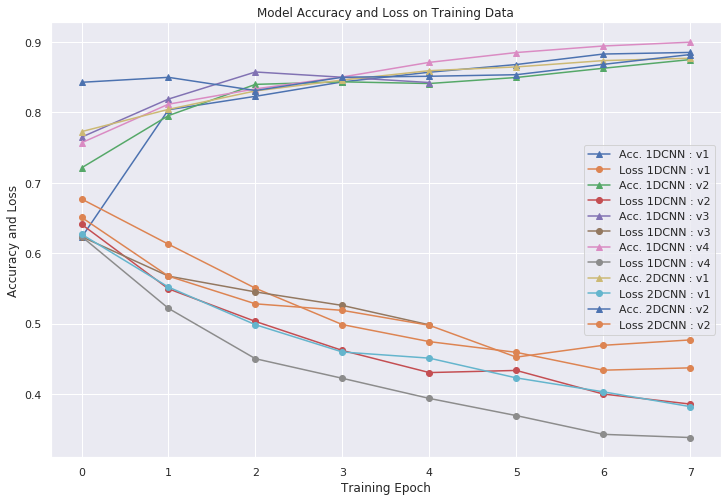

In [6]:
import seaborn as sns
sns.set()
print("\n Learning curve of model training \n")
# summarize history for accuracy and loss
plt.figure(figsize=(12, 8))
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        label_acc = 'Acc. {} : {}'.format(model_type, arch_type)
        label_lss = 'Loss {} : {}'.format(model_type, arch_type)
        plt.plot(all_history[model_type][arch_type].history['accuracy'], "^-", label=label_acc)
        plt.plot(all_history[model_type][arch_type].history['loss'], "o-", label=label_lss)
plt.title('Model Accuracy and Loss on Training Data')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.legend(loc='best')
plt.savefig('All_Models_Accuracies_Training.png', bbox_inches='tight')
plt.show()

In [7]:
# Default parameters
N_SAMPLES_T = X_test.shape[0] 
N_OBS_T = N_SAMPLES_T*N_SEGMENTS

print("""Parameters used for TEST MODEL:
         N_SAMPLES     = {},
         TIME_SAMPLES  = {}, 
         N_SEGMENTS    = {}, 
         N_CHANNELS    = {},
         N_OBS         = {}""".format(N_SAMPLES_T, TIME_SAMPLES, N_SEGMENTS, N_CHANNELS, N_OBS_T))

# Define input data to feed into the CNN
X_test, y_test = dataset_segmentation(X_test, y_test, N_SAMPLES_T, N_SEGMENTS, TIME_SAMPLES, N_CHANNELS, info=True)
print("""Segmentation of y_test --> #(0 Labels) : {}, #(1 Labels) : {}\n""".format(sum(y_test == 0), sum(y_test == 1)))
X_test = X_test.reshape((N_OBS_T, TIME_SAMPLES*N_CHANNELS))
X_test = feature_normalize(X_test)
y_test = to_categorical(y_test.reshape((N_OBS_T,)))

Parameters used for TEST MODEL:
         N_SAMPLES     = 284,
         TIME_SAMPLES  = 500, 
         N_SEGMENTS    = 40, 
         N_CHANNELS    = 7,
         N_OBS         = 11360
New segmented X dataset shape: (11360, 500, 7), y dataset shape: (11360,)

Segmentation of y--> #(0 Labels) : 11298, #(1 Labels) : 62

Segmentation of y_test --> #(0 Labels) : 11298, #(1 Labels) : 62



In [8]:
# Make predictions for testing sets on each one of the trained models
all_scores = {
    '1DCNN': {
        'v1': None,
        'v2': None,
        'v3': None,
        'v4': None,
    },
    '2DCNN': {
        'v1': None,
        'v2': None
    }
}
# Iterate over each architecture and model, using a single dictionary
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        print("\nComputing score on test dataset for model {} with architecture {}".format(model_type, arch_type))
        all_scores[model_type][arch_type] = all_models[model_type][arch_type].evaluate(X_test, y_test, verbose=1)
        print("\nAccuracy: {:0.2f}, Loss: {:0.2f}".format(all_scores[model_type][arch_type][1], all_scores[model_type][arch_type][0]))
        #print("\nAccuracy on test data: %0.2f" % score[1])
        #print("\nLoss on test data: %0.2f" % score[0])


Computing score on test dataset for model 1DCNN with architecture v1
11360/11360 [==============================] - 1s 113us/sample - loss: 0.6953 - accuracy: 0.9770

Accuracy: 0.98, Loss: 0.70

Computing score on test dataset for model 1DCNN with architecture v2
11360/11360 [==============================] - 1s 106us/sample - loss: 0.5891 - accuracy: 0.9770

Accuracy: 0.98, Loss: 0.59

Computing score on test dataset for model 1DCNN with architecture v3
11360/11360 [==============================] - 2s 143us/sample - loss: 0.8511 - accuracy: 0.9770

Accuracy: 0.98, Loss: 0.85

Computing score on test dataset for model 1DCNN with architecture v4
11360/11360 [==============================] - 2s 141us/sample - loss: 0.3040 - accuracy: 0.9770

Accuracy: 0.98, Loss: 0.30

Computing score on test dataset for model 2DCNN with architecture v1
11360/11360 [==============================] - 3s 256us/sample - loss: 0.2657 - accuracy: 0.9770

Accuracy: 0.98, Loss: 0.27

Computing score on test 

In [9]:
# Default parameters for testing
print("Retrieve prediction on testing dataset X to submit...")

# Default parameters
N_SAMPLES = iX_test.shape[0] #946
TIME_SAMPLES = 500 # Its fixed, at 500!
N_SEGMENTS = 10 # Can be changed, 40 the max!
N_CHANNELS = 7 # Its fixed, at 7!
N_OBS = N_SAMPLES*N_SEGMENTS

print("""Parameters used for PREDICTION MODEL:
         N_SAMPLES     = {},
         TIME_SAMPLES  = {}, 
         N_SEGMENTS    = {}, 
         N_CHANNELS    = {},
         N_OBS         = {}""".format(N_SAMPLES, TIME_SAMPLES, N_SEGMENTS, N_CHANNELS, N_OBS))


# Define input data to feed into the CNN
X_pred = dataset_segmentation(iX_test, _, N_SAMPLES, N_SEGMENTS, TIME_SAMPLES, N_CHANNELS, info=True, validation=True)
X_pred = X_pred.reshape((N_OBS, TIME_SAMPLES*N_CHANNELS))
X_pred = feature_normalize(X_pred, info=True)


# Make predictions on the testing set to submit!
all_predictions = {
    '1DCNN': {
        'v1': None,
        'v2': None,
        'v3': None,
        'v4': None,
    },
    '2DCNN': {
        'v1': None,
        'v2': None
    }
}
all_predicted_classes = {
    '1DCNN': {
        'v1': None,
        'v2': None,
        'v3': None,
        'v4': None,
    },
    '2DCNN':{
        'v1': None,
        'v2': None
    }
}

print("Predictions on testing dataset for submission...")
# Iterate over each architecture and model, using a single dictionary
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        print("\nComputing predictions on testing dataset for model {} with architecture {}".format(model_type, arch_type))
        all_predictions[model_type][arch_type] = all_models[model_type][arch_type].predict(X_pred)
        all_predicted_classes[model_type][arch_type] = np.argmax(all_predictions[model_type][arch_type], axis=1)
        print("Predicted classes with 1: {}".format(sum(all_predicted_classes[model_type][arch_type] == 1)))
        print("Predicted classes with 0: {}".format(sum(all_predicted_classes[model_type][arch_type] == 0)))

Retrieve prediction on testing dataset X to submit...
Parameters used for PREDICTION MODEL:
         N_SAMPLES     = 946,
         TIME_SAMPLES  = 500, 
         N_SEGMENTS    = 10, 
         N_CHANNELS    = 7,
         N_OBS         = 9460

New segmented X dataset shape: (9460, 500, 7)
Normalized dataset of shape (9460, 3500)
                 5 first means: [ 1.1664572 -1.3824425 -1.5205032  2.2606065] 
                 5 first vars : [137.1565  177.11403 140.68715 141.76039]

Predictions on testing dataset for submission...

Computing predictions on testing dataset for model 1DCNN with architecture v1
Predicted classes with 1: 914
Predicted classes with 0: 8546

Computing predictions on testing dataset for model 1DCNN with architecture v2
Predicted classes with 1: 946
Predicted classes with 0: 8514

Computing predictions on testing dataset for model 1DCNN with architecture v3
Predicted classes with 1: 919
Predicted classes with 0: 8541

Computing predictions on testing dataset for mo

In [12]:
# Iterate over each architecture and model, using a single dictionary
for model_type in all_model_types:
    for arch_type in all_arch_types[model_type]:
        print("\nCreating output predictions from testing dataset for model {} with architecture {}".format(model_type, arch_type))
        pred_classes_final = dataset_back_to_original(model_type, arch_type, all_predicted_classes[model_type][arch_type], 
                                                      N_SAMPLES, N_SEGMENTS, export=True, use_average=True)
        sum_1s = sum(pred_classes_final==1)
        per_1s = sum_1s/len(pred_classes_final)
        sum_0s = sum(pred_classes_final==0)
        per_0s = sum_0s/len(pred_classes_final)
        print("""Predicted classes with 1: {}, {:.5f}%, with 0: {}, {:.5f}% -- Label_1/Label_0 : {:.5f}%""".format(
            sum_1s, per_1s, sum_0s, per_0s, sum_1s/sum_0s))


Creating output predictions from testing dataset for model 1DCNN with architecture v1
Predicted classes with 1: 95, 0.10042%, with 0: 851, 0.89958% -- Label_1/Label_0 : 0.11163%

Creating output predictions from testing dataset for model 1DCNN with architecture v2
Predicted classes with 1: 95, 0.10042%, with 0: 851, 0.89958% -- Label_1/Label_0 : 0.11163%

Creating output predictions from testing dataset for model 1DCNN with architecture v3
Predicted classes with 1: 95, 0.10042%, with 0: 851, 0.89958% -- Label_1/Label_0 : 0.11163%

Creating output predictions from testing dataset for model 1DCNN with architecture v4
Predicted classes with 1: 95, 0.10042%, with 0: 851, 0.89958% -- Label_1/Label_0 : 0.11163%

Creating output predictions from testing dataset for model 2DCNN with architecture v1
Predicted classes with 1: 95, 0.10042%, with 0: 851, 0.89958% -- Label_1/Label_0 : 0.11163%

Creating output predictions from testing dataset for model 2DCNN with architecture v2
Predicted classes 

In [13]:
tf.__version__

'2.1.0'